# Determinantes

In [1]:
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows',999)
import numpy as np
import os
import warnings
import unicodedata
warnings.filterwarnings("ignore")
from io import BytesIO
import gzip
import requests

In [190]:
distances = pd.read_excel('matrix_distance/estimations/distances.xlsx', index_col = 0)

In [191]:
cwpops = pd.read_excel('matrix_distance/estimations/cwpops.xlsx', index_col = [0,1])

In [229]:
cwpops.loc['Mexico'].head()

,masalarial,avg_wg,index1,nearest_wg,nearest_loc,parsed_duration,beam_pop,proy2019,censo2010,pops,estimated_citywage
City,,,,,,,,,,,
Acayucan,NaN,NaN,"('Mexico', 'Acayucan')",4.055107,"('Mexico', 'Zona metropolitana de Villahermosa')",2.816667,102992.0,NaN,NaN,102992,4.176436e+05
Acuna,NaN,NaN,"('Mexico', 'Acuna')",5.443959,"('Mexico', 'Zona metropolitana de Saltillo')",5.566667,108159.0,NaN,NaN,108159,5.888132e+05
Campeche,NaN,NaN,"('Mexico', 'Campeche')",4.321488,"('Mexico', 'Zona metropolitana de Mérida')",2.383333,190813.0,NaN,NaN,190813,8.245962e+05
Celaya,NaN,NaN,"('Mexico', 'Celaya')",5.131556,"('Mexico', 'Zona metropolitana de Querétaro')",0.833333,277750.0,NaN,NaN,277750,1.425290e+06
Chetumal,NaN,NaN,"('Mexico', 'Chetumal')",4.302340,"('Mexico', 'Zona metropolitana de Cancún')",4.850000,121602.0,NaN,NaN,121602,5.231731e+05


In [195]:
latlongs = distances[['Country','City A','Point A']].set_index(['Country','City A']).drop_duplicates().rename(
    columns = {'Point A':'latlong'}).dropna()
latlongs[['lat','long']] = latlongs['latlong'].apply(lambda x: pd.Series(x.split(','))).astype(float)
latlongs = latlongs.drop('latlong', axis = 1)

In [197]:
latlongs = latlongs.join(cwpops[['masalarial','estimated_citywage']])
latlongs = gpd.GeoDataFrame(
    latlongs, geometry=gpd.points_from_xy(latlongs.long, latlongs.lat))

In [200]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

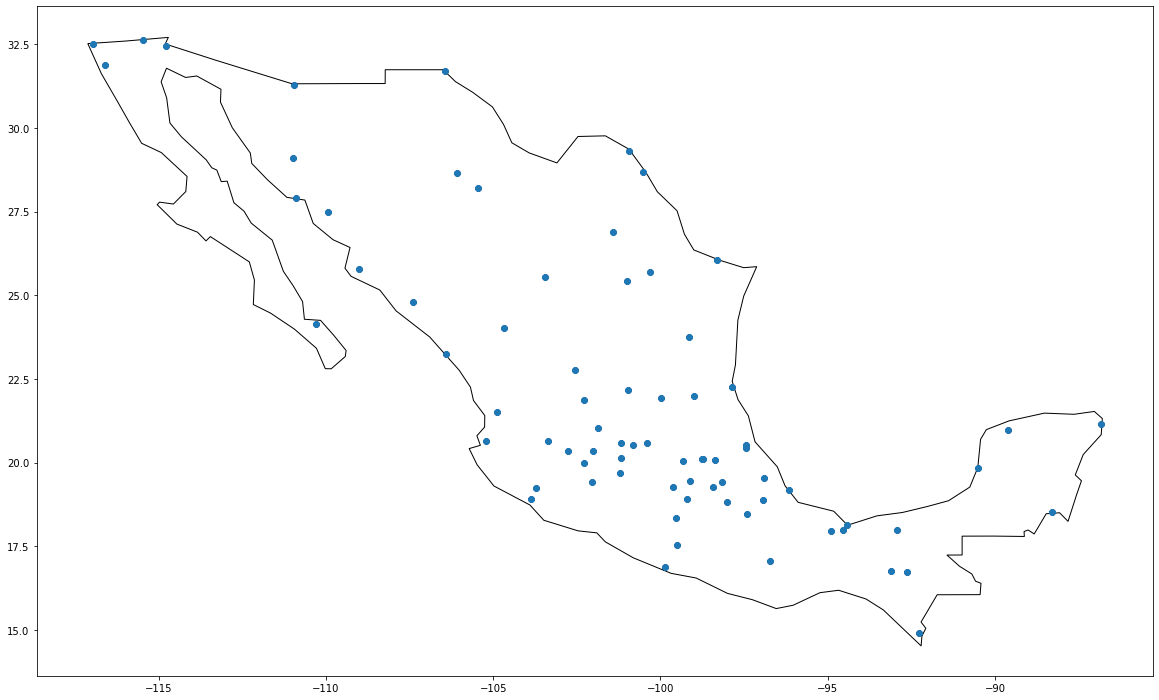

In [227]:
ax = world[world['name'] == 'Mexico'].plot(color='white', edgecolor='black', figsize = (20,20))

latlongs.loc['Mexico'].dropna().plot(ax = ax, legend = True, markersize = 25)

Arreglamos strings

In [2]:
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text).strip()

In [3]:
fix = {'Villahermosa (Centro)':'Villahermosa',
       'Oaxaca de Juarez':'Oaxaca', 
       'Mexico City':'Ciudad de Mexico',
       'Mexico DF':'Ciudad de Mexico',
      'Vera Cruz':'Veracruz'}

### Arrancar aquí con un mapa de Mex donde se resalten las ciudades que serán estudiadas en un mapa, y al lado diga la población, salario y masa salarial de cada una en un cuadrito (o algo así, como intro), otro tema, ya desde el vamos quedemonos con los países de Latam, descartemos todo el resto, si querés dejemos USA para tener quizás en algun indicador una referencia de país desarrollado pero nada más. Siempre pongamos en cada tablita una nota o algo con la fuente de los datos

### Conectividad interna

#### M-Lab

In [4]:
mlab = pd.read_excel('mlab/mlab_data_city.xlsx')
mlab['City'] = mlab['City'].apply(strip_accents).replace(fix)
mlab = mlab.sort_values(
    ['Country','City', '# Download', '# Upload']).drop_duplicates(subset = ['Country','City'], keep = 'last')

In [5]:
mlab.shape

(127846, 6)

#### Enterprise Surveys (World Bank)

In [6]:
es = pd.read_excel('worldbankdatabases/ES/ES_data_bylocation.xlsx', header = [0,1,2])

es.iloc[:,:3] = es.iloc[:,:3].fillna(method = 'ffill')

es.columns = [x[0]+': '+ x[1] if 'Unnamed' not in x[0] else x[2] for x in es.columns.tolist()]
es = es[es['Average/SE/N'] == 'Average'].drop('Average/SE/N', axis = 1)
es = es.dropna(subset = ['Year'])
es['Year'] = es['Year'].astype(int)
es.iloc[:,3:] = es.iloc[:,3:].replace('n.a.', np.nan).apply(lambda x: pd.to_numeric(x))

In [7]:
latest = []
for economy in es['Economy'].unique():
    df = es[es['Economy'] == economy]
    df = df[(df['Year'] == df['Year'].max())&(df['Subgroup Level'] != 'All')]
    latest.append(df)

es_latest = pd.concat(latest)
es_latest['Subgroup Level'] = es_latest['Subgroup Level'].apply(strip_accents).replace(fix)
es_latest = es_latest.drop('Year', axis = 1)
es_latest = es_latest.rename(columns = {'Economy':'Country','Subgroup Level':'City'})
es_conectividad_interna = 'Biggest Obstacle: Percent of firms choosing transportation as their biggest obstacle'

In [8]:
conect_intern = mlab.set_index(['Country','City']).join(
    es_latest.set_index(['Country','City'])[es_conectividad_interna], how = 'outer'
).sort_values(by = ['Country','City'])

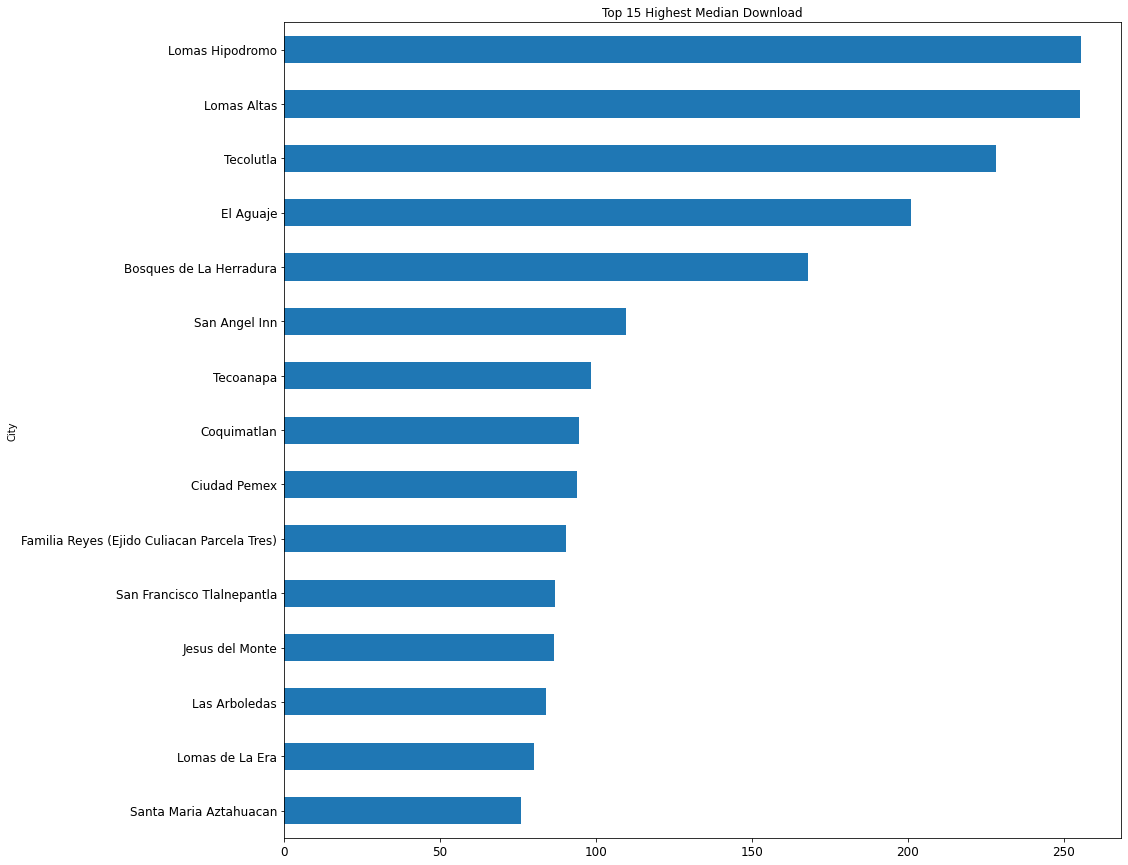

In [152]:
conect_intern.loc['Mexico']['Median Download'].dropna().sort_values().tail(15).plot(
    kind = 'barh', figsize = (15,15), fontsize = 12, title = 'Top 15 Highest Median Download')

### [Aquí hacer un gráfico de barras con las ciudades de Mexico, diria de poner solo median download (aclararlo en notas del gráfico) y uno con el indicador de ES]

### Conectividad externa

#### OpenFlights.org

Calculamos rutas sumando vuelos fuente y vuelos destino esto que vaya como nota en el gráfico que pido abajo

In [10]:
air_data = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports-extended.dat', header = None)
#https://openflights.org/data.html
air_data.columns = [
    'Airport ID',
    'Name','City','Country','IATA','ICAO','Latitude',
    'Longitude','Altitude','Timezone','DST','Tz database time zone',
    'Type','Source'
]

routes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat',
                    header = None)

routes.columns = ['Airline',
'Airline ID',
'Source airport', # 3-letter (IATA) or 4-letter (ICAO) code of the source airport.
'Source airport ID',
'Destination airport', # 3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
'Destination airport ID',
'Codeshare', #  "Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
'Stops',
'Equipment']

air_data['Airport ID'] = air_data['Airport ID'].astype('str')
air_data.loc[air_data['Name'].str.lower().str.contains('international'),'int'] = 1
air_data.loc[~air_data['Name'].str.lower().str.contains('international'),'int'] = 0
sources = routes.groupby('Source airport ID').size()
dests = routes.groupby('Destination airport ID').size()

air_data = air_data.set_index('Airport ID').join(sources.to_frame('Sourceflights')).join(dests.to_frame('Destinationflights')).reset_index().dropna()

rutas = air_data[['Country','City','Name','Sourceflights','Destinationflights']].reset_index()
rutas['Routes'] = rutas[['Sourceflights','Destinationflights']].mean(1).dropna().apply(round)
rutas = rutas[['Country','City','Name','Routes']].sort_values(by = 'Routes', ascending = False).dropna()
air_data['City'] = air_data['City'].apply(strip_accents).replace(fix)
air_data['routes'] = air_data[['Sourceflights','Destinationflights']].sum(1)

airports_per_city = air_data.groupby(['Country','City']).size()
intlairp_per_city = air_data.groupby(['Country','City']).sum()['int']
routes_per_city = air_data.groupby(['Country','City']).sum()['routes']

final_air_data = pd.concat([airports_per_city.to_frame('n_airports'),intlairp_per_city,routes_per_city], axis = 1)

In [11]:
conect_extern = mlab.set_index(['Country','City']).join(final_air_data)

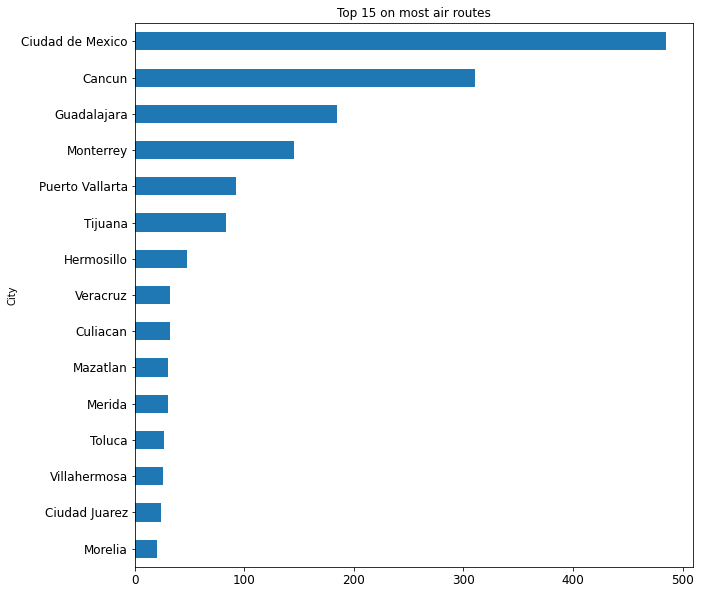

In [83]:
conect_extern.loc['Mexico'].dropna()['routes'].sort_values().tail(15).plot(
    kind = 'barh', figsize = (10,10), fontsize = 12, title = 'Top 15 on most air routes')

In [25]:
def get_wages_from_cutoff(city_index, cutoff = 2):
    #print(city_index)
    city_wage = cwpops.loc[city_index]['estimated_citywage']
    distan = distances[(distances['Country'] == city_index[0])
                            &(distances['City A'] == city_index[1])
                            &(distances['parsed_duration'] <= cutoff)].dropna()

    nearby_cities = [(x,y) for x,y in distan[['Country','City B']].values.tolist()]
    if len(nearby_cities) == 0:
        return city_wage
    else:
        nearby_wages = cwpops.loc[nearby_cities]['estimated_citywage'].sum()
        return nearby_wages + city_wage

In [26]:
def get_countryshare_from_cutoff(city_index, cutoff = 5):
#city_index = ('Argentina','Ciudad de Buenos Aires')
#cutoff = 2
    #print(city_index)
    nearwages = get_wages_from_cutoff(city_index, cutoff = cutoff)
    country_wages = cwpops.groupby('Country')['estimated_citywage'].sum()[city_index[0]]
    share = nearwages/country_wages
    return share

In [29]:
shares_cutoff = pd.DataFrame(index = cwpops.index)
shares_cutoff['index1'] = shares_cutoff.index
for i in range(6):
    shares_cutoff['cutoff_' + str(i)] = shares_cutoff['index1'].apply(get_countryshare_from_cutoff, cutoff = i)

In [153]:
cwpops.head()

masalarial    avg_wg  \
Country   City                                                    
Argentina Bahia Blanca-Cerri             2.775744e+06  7.124361   
          Ciudad de Buenos Aires         4.394650e+07  9.871347   
          Comodoro Rivadavia-Rada Tilly  1.860508e+06  9.554098   
          Concordia                      7.616305e+05  5.365976   
          Corrientes                     1.716742e+06  4.532101   

                                                                                 index1  \
Country   City                                                                            
Argentina Bahia Blanca-Cerri                        ('Argentina', 'Bahia Blanca-Cerri')   
          Ciudad de Buenos Aires                ('Argentina', 'Ciudad de Buenos Aires')   
          Comodoro Rivadavia-Rada Tilly  ('Argentina', 'Comodoro Rivadavia-Rada Tilly')   
          Concordia                                          ('Argentina', 'Concordia')   
          Corrientes                                        ('Argentina', 'Corrientes')   

                                         nearest_wg  \
Country   City                                        
Argentina Bahia Blanca-Cerri               7.124361   
          Ciudad de Buenos Aires           9.871347   
          Comodoro Rivadavia-Rada Tilly    9.554098   
          Concordia                        5.365976   
          Corrientes                       4.532101   

                                                                            nearest_loc  \
Country   City                                                                            
Argentina Bahia Blanca-Cerri                        ('Argentina', 'Bahia Blanca-Cerri')   
          Ciudad de Buenos Aires                ('Argentina', 'Ciudad de Buenos Aires')   
          Comodoro Rivadavia-Rada Tilly  ('Argentina', 'Comodoro Rivadavia-Rada Tilly')   
          Concordia                                          ('Argentina', 'Concordia')   
          Corrientes                                        ('Argentina', 'Corrientes')   

                                         parsed_duration  beam_pop   proy2019  \
Country   City                                                                  
Argentina Bahia Blanca-Cerri                         0.0       NaN   309544.0   
          Ciudad de Buenos Aires                     0.0       NaN  3075646.0   
          Comodoro Rivadavia-Rada Tilly              0.0       NaN   242351.0   
          Concordia                                  0.0  131716.0   170003.0   
          Corrientes                                 0.0  316782.0        NaN   

                                         censo2010     pops  \
Country   City                                                
Argentina Bahia Blanca-Cerri              301572.0   309544   
          Ciudad de Buenos Aires         2890000.0  3075646   
          Comodoro Rivadavia-Rada Tilly   182631.0   242351   
          Concordia                       149450.0   170003   
          Corrientes                      352646.0   352646   

                                         estimated_citywage  
Country   City                                               
Argentina Bahia Blanca-Cerri                   2.205303e+06  
          Ciudad de Buenos Aires               3.036077e+07  
          Comodoro Rivadavia-Rada Tilly        2.315445e+06  
          Concordia                            9.122320e+05  
          Corrientes                           1.598227e+06

In [30]:
shares_cutoff.head()

index1  \
Country   City                                                                        
Argentina Bahia Blanca-Cerri                        (Argentina, Bahia Blanca-Cerri)   
          Ciudad de Buenos Aires                (Argentina, Ciudad de Buenos Aires)   
          Comodoro Rivadavia-Rada Tilly  (Argentina, Comodoro Rivadavia-Rada Tilly)   
          Concordia                                          (Argentina, Concordia)   
          Corrientes                                        (Argentina, Corrientes)   

                                         cutoff_0  cutoff_1  cutoff_2  \
Country   City                                                          
Argentina Bahia Blanca-Cerri             0.011226  0.011226  0.011226   
          Ciudad de Buenos Aires         0.154551  0.649061  0.656603   
          Comodoro Rivadavia-Rada Tilly  0.011787  0.011787  0.011787   
          Concordia                      0.004644  0.004644  0.004644   
          Corrientes                     0.008136  0.015559  0.015559   

                                         cutoff_3  cutoff_4  cutoff_5  
Country   City                                                         
Argentina Bahia Blanca-Cerri             0.011226  0.017859  0.021465  
          Ciudad de Buenos Aires         0.661993  0.703915  0.735604  
          Comodoro Rivadavia-Rada Tilly  0.011787  0.011787  0.011787  
          Concordia                      0.004644  0.025364  0.716347  
          Corrientes                     0.021267  0.028124  0.028124

### Aquí un par de cosas:
### a) tema airports: ya buscar un cutoff para el tema rutas, propongo que si la cantidad de rutas está en del aeropuerto es mayor al 20 cuartil de la distribución del país (es decir, ordenados por cantidad de rutas que tienen, quedarnos con el 80% que está arriba), tomemos como "airport bueno" y de lo contrario "airport malo". Una vez hecho esto, ya calcular distancias y dejar el dato de distancia como el dato de la tabla
### b) Teníamos alguna data de puertos, pongamos la distancia al puerto más cercano y aclaremos en nota que hay que realizar aún ajuste por calidad al dato de puerto
### c) Acceso a mercados: ya te pasé el dato de población, avisame como venís con eso, deberíamos ya ser capaces de poder hacer el indicador. Este indicador fijate lo que habíamos puesto en la tabla
##### "El indicador de acceso a mercados será calculado utilizado distintas distancias medidas en horas, a partir de la masa salarial con la que la ciudad está conectada, en relación al total del país. Por ejemplo, la ciudad de La Plata tiene a una hora de distancia su propia masa salarial, la de Gran Buenos Aires y la de la Ciudad de Buenos Aires. Para calcular el indicador para 1 hora de distancia de La Plata, se suman las masas salariales de las tres ciudades y se dividen por el total del país, obteniendo el porcentaje al que se tiene acceso. A medida que la distancia (siempre medida en horas) se agranda, más cantidad de ciudades se toman en cuenta en el numerador, ampliando la masa salarial con la que la ciudad está conectada"
### Primero hacer con 2 horas como cutoff. Luego lo que habíamos hablado con CAF era hacer un mapa con un slider que permita aumentar las horas (discreto: 0, 1 , 2, 3 , 4, 5) y que se pueda ver en un mapa como aparecen nuevos mercados a los que se tiene acceso, y que haya una tablita que ordene las ciudades según el % de la masa salarial del país a la que se tiene acceso, y muestre dicho porcentaje. Esto lo charlamos cualquier cosa


### Trabajo y conocimiento

In [120]:
tabla_ejd = pd.read_excel('tabla_ancha.xlsx', index_col = [0,1])

In [147]:
tabla_ejd.head()

salario_real  salario_estimado  wages_ s1  \
pais Ciudad                                                                     
ARG  Bahia Blanca-Cerri                 7.120378          6.269420   8.469147   
     Ciudad de Buenos Aires             9.866524          6.842218  13.660703   
     Comodoro Rivadavia-Rada Tilly      9.552440          6.322676  14.323252   
     Concordia                          5.357280          6.311558   3.717866   
     Corrientes                         4.511070          6.498688   5.268988   

                                    wages_ s2  wages_ s3  wages_ s4  \
pais Ciudad                                                           
ARG  Bahia Blanca-Cerri              5.294685   8.839227   5.602795   
     Ciudad de Buenos Aires         10.014727  12.117310   7.379862   
     Comodoro Rivadavia-Rada Tilly   6.083860   9.799408   8.154986   
     Concordia                       4.660693   4.810529   4.080579   
     Corrientes                      3.475080   4.682111   3.539272   

                                    wages_ s5  wages_ s6  wages_ s7  \
pais Ciudad                                                           
ARG  Bahia Blanca-Cerri              5.737664   7.498426   7.966132   
     Ciudad de Buenos Aires          6.892054   8.943036  11.306550   
     Comodoro Rivadavia-Rada Tilly   7.238176   9.862985  11.016696   
     Concordia                       4.082755   5.494599   6.314598   
     Corrientes                      3.285188   3.744978   5.607633   

                                    wages_ s8  ...  share_emp_s2  \
pais Ciudad                                    ...                 
ARG  Bahia Blanca-Cerri              8.068625  ...      0.054505   
     Ciudad de Buenos Aires         12.700519  ...      0.049541   
     Comodoro Rivadavia-Rada Tilly  10.848811  ...      0.037047   
     Concordia                       7.395921  ...      0.070213   
     Corrientes                      5.993036  ...      0.034899   

                                    share_emp_s3  share_emp_s4  share_emp_s5  \
pais Ciudad                                                                    
ARG  Bahia Blanca-Cerri                 0.056045      0.096860      0.264649   
     Ciudad de Buenos Aires             0.054730      0.033429      0.204363   
     Comodoro Rivadavia-Rada Tilly      0.033555      0.114745      0.215390   
     Concordia                          0.020382      0.091760      0.256504   
     Corrientes                         0.018891      0.101719      0.249294   

                                    share_emp_s6  share_emp_s7  share_emp_s8  \
pais Ciudad                                                                    
ARG  Bahia Blanca-Cerri                 0.078214      0.070207      0.060698   
     Ciudad de Buenos Aires             0.066950      0.189249      0.073584   
     Comodoro Rivadavia-Rada Tilly      0.088615      0.078939      0.067659   
     Concordia                          0.061767      0.063756      0.074080   
     Corrientes                         0.061233      0.075913      0.112593   

                                    share_emp_s9  share_emp_s10  emp_ciudad  
pais Ciudad                                                                  
ARG  Bahia Blanca-Cerri                 0.209909       0.084313      392255  
     Ciudad de Buenos Aires             0.264883       0.054699     4472427  
     Comodoro Rivadavia-Rada Tilly      0.163893       0.062080      195023  
     Concordia                          0.216752       0.083119      143265  
     Corrientes                         0.240998       0.087960      386427  

[5 rows x 33 columns]

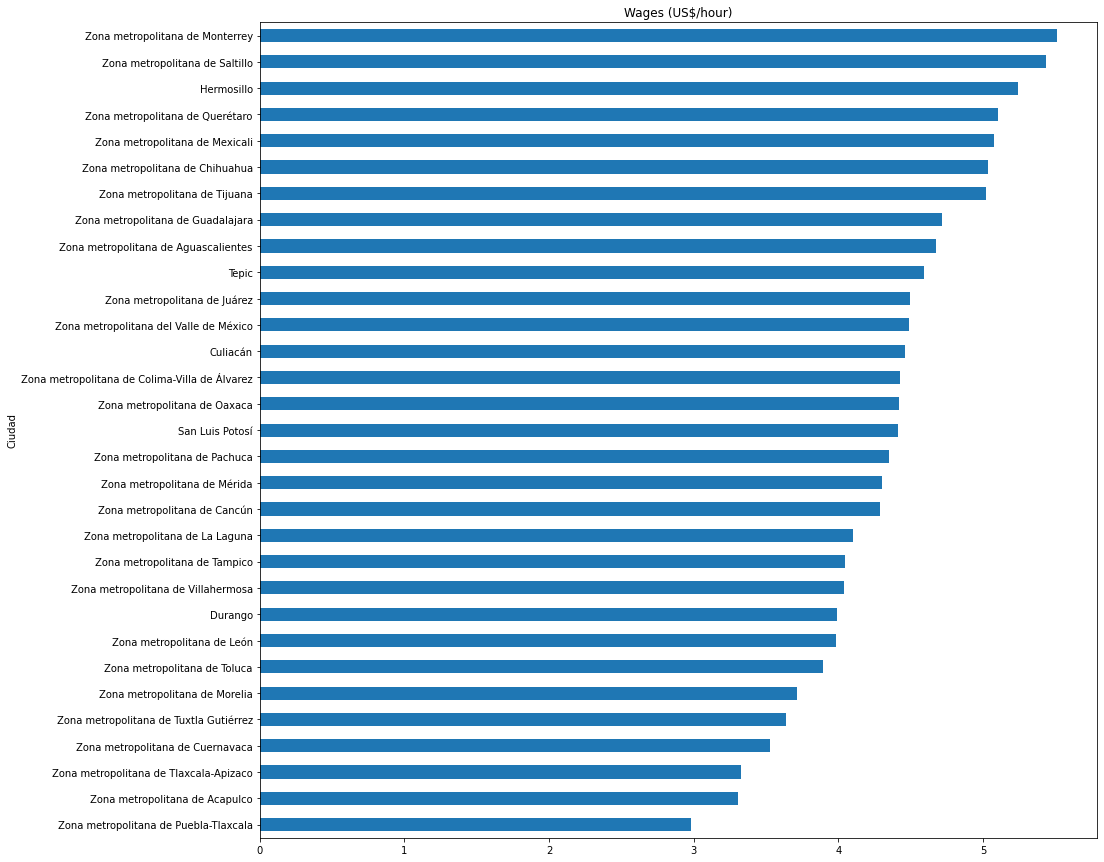

In [144]:
tabla_ejd.loc['MEX']['salario_real'].sort_values().plot(kind = 'barh', figsize = (15,15), title = 'Wages (US$/hour)')

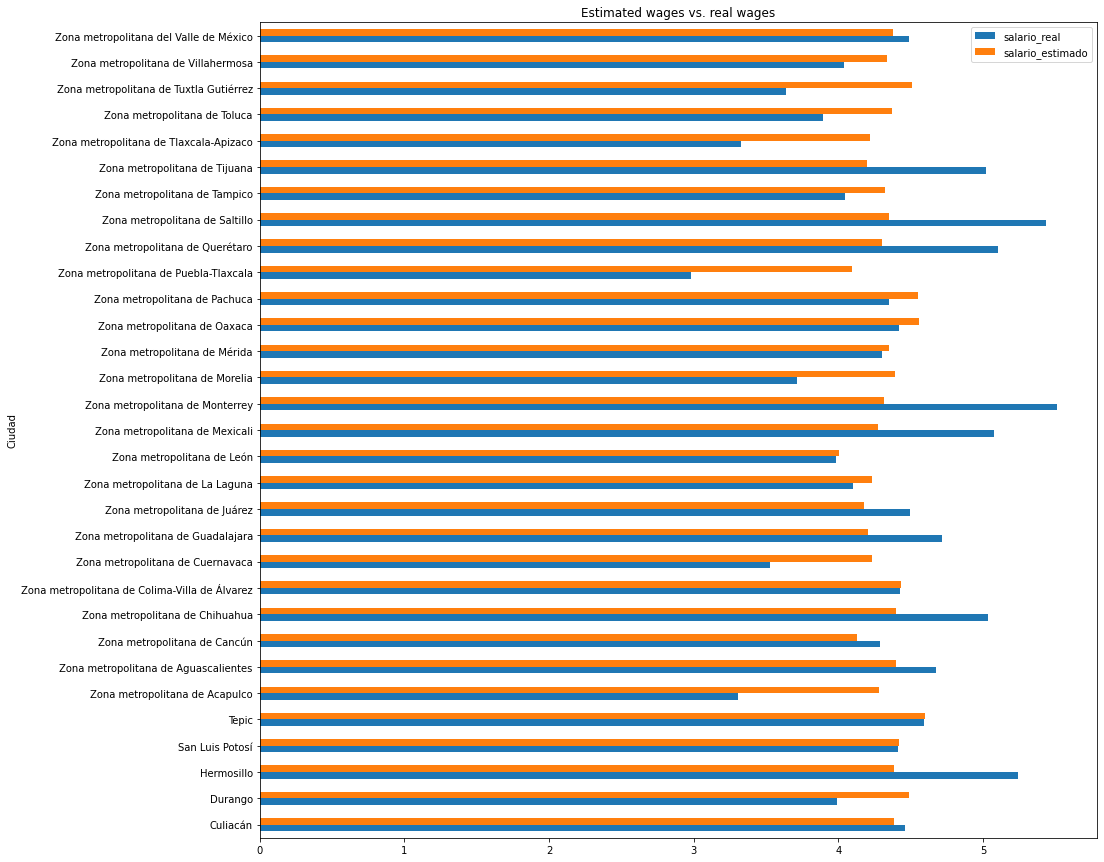

In [149]:
tabla_ejd.loc['MEX'][['salario_real','salario_estimado']].plot(kind = 'barh', figsize = (15,15), title = 'Estimated wages vs. real wages')

### Jero, acá hay un par de cosas que hacer
### en la base D que te pasé, de donde armamos las masas salariales, también tenemos la cantidad de personas que están en la informalidad y la cantidad de hombres sobre el total, con eso podemos armar el indicador de informalidad  y de género
### También tenemos numero de trabajadores por nivel de educación 1, 2 y 3. No aparece en la tabla pero armemos un indicador con esto (simple en realidad no armar nada, poner en la tabla el dato de % / total en educ 1, en educ 2 y en educ 3).
### Faltarían Desempleo, los indicadores de educación que habíamos puesto: % secundario comp., % estudiando uni o terciario, % con estudios uni y  NBI. Estos deberíamos buscarlos para las cinco ciudades.Luego está lo de hoteles, que lo dejamos anotado como que falta.

Buscarlo para las 5 ciudades que tenemos.

### Fijate que conviene más, una opcion es meter un toque de google, total son 5 ciudades, y completar. Otra es buscar directamente en la data, acá encontré esto, que para usarlo hay que tener windows: https://www.inegi.org.mx/programas/enoe/15ymas/default.html#Tabulados, quizás buscando en google es más straightforward al ser solo 5 ciudades... Qué decis?
### hotel que quede mencionado que falta nomás


In [95]:
es_tyc = 'Biggest Obstacle: Percent of firms choosing inadequately educated workforce as their biggest obstacle'

In [96]:
es_latest.set_index(['Country','City'])[es_tyc].to_frame().head()

Biggest Obstacle: Percent of firms choosing inadequately educated workforce as their biggest obstacle
Country     City                                                                                                                 
Afghanistan Herat                                                         5.3                                                    
            Jalalabad                                                     2.7                                                    
            Kabul                                                         1.9                                                    
            Kandahar                                                      2.9                                                    
            Mazar-E-Sharif                                                0.0

In [97]:
es_latest.set_index(['Country','City']).loc['Mexico'][es_tyc].to_frame().head()

,Biggest Obstacle: Percent of firms choosing inadequately educated workforce as their biggest obstacle
City,
Coahuila,23.6
Estado de Mexico,3.1
Guanajuato,1.9
Jalisco,1.2
Ciudad de Mexico,1.6


### Conglomerados y cadenas de valor

In [145]:
ejd_HH = pd.read_excel('analisis_ejd.xlsx', index_col = [0,1])

In [146]:
ejd_HH.head()

principal_sector           HH  \
Pais Ciudad                                                        
ARG  Bahia Blanca-Cerri                          s9  1588.576953   
     Ciudad de Buenos Aires                      s9  1793.556338   
     Comodoro Rivadavia-Rada Tilly               s1  1376.673745   
     Concordia                                   s9  1766.704503   
     Corrientes                                  s9  1853.123446   

                                    principal_sector_share     HH_pais  \
Pais Ciudad                                                              
ARG  Bahia Blanca-Cerri                           0.280838  1560.07132   
     Ciudad de Buenos Aires                       0.301001  1560.07132   
     Comodoro Rivadavia-Rada Tilly                0.207036  1560.07132   
     Concordia                                    0.324554  1560.07132   
     Corrientes                                   0.328981  1560.07132   

                                      esp_HH  country_principal_sector_share  \
Pais Ciudad                                                                    
ARG  Bahia Blanca-Cerri             1.018272                        0.276779   
     Ciudad de Buenos Aires         1.149663                        0.276779   
     Comodoro Rivadavia-Rada Tilly  0.882443                        0.029475   
     Concordia                      1.132451                        0.276779   
     Corrientes                     1.187845                        0.276779   

                                    principal_sector_country_comparison  \
Pais Ciudad                                                               
ARG  Bahia Blanca-Cerri                                        1.014667   
     Ciudad de Buenos Aires                                    1.087514   
     Comodoro Rivadavia-Rada Tilly                             7.024118   
     Concordia                                                 1.172610   
     Corrientes                                                1.188605   

                                     nivedu1   nivedu2   nivedu3     mujer  \
Pais Ciudad                                                                  
ARG  Bahia Blanca-Cerri             0.274568  0.389155  0.336277  0.421032   
     Ciudad de Buenos Aires         0.104991  0.365109  0.529900  0.473707   
     Comodoro Rivadavia-Rada Tilly  0.246170  0.498780  0.255050  0.382404   
     Concordia                      0.358038  0.406068  0.235894  0.389366   
     Corrientes                     0.220363  0.424747  0.354890  0.427486   

                                      hombre    formal  informal  
Pais Ciudad                                                       
ARG  Bahia Blanca-Cerri             0.578968  0.564495  0.435505  
     Ciudad de Buenos Aires         0.526293  0.714282  0.285718  
     Comodoro Rivadavia-Rada Tilly  0.617596  0.731100  0.268900  
     Concordia                      0.610634  0.593948  0.406052  
     Corrientes                     0.572514  0.606350  0.393650

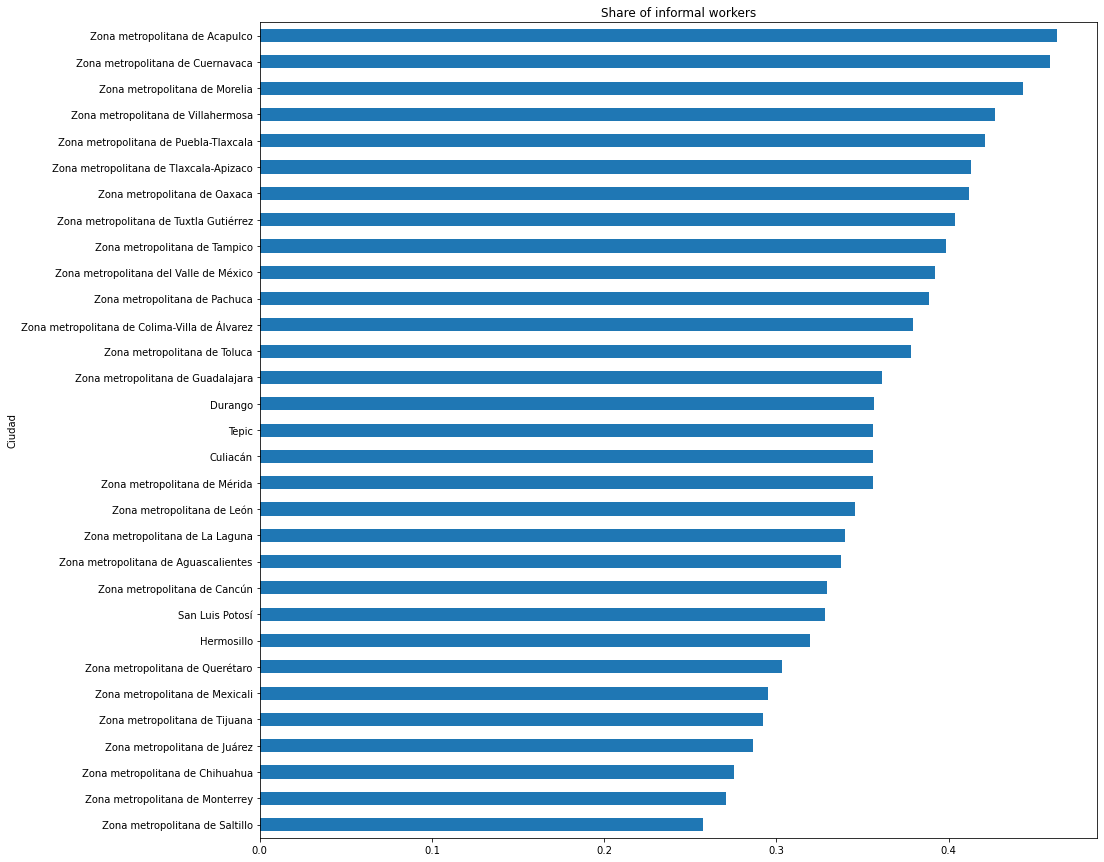

In [136]:
ejd_HH.loc['MEX']['informal'].sort_values().plot(kind = 'barh', figsize = (15,15), title = 'Share of informal workers')

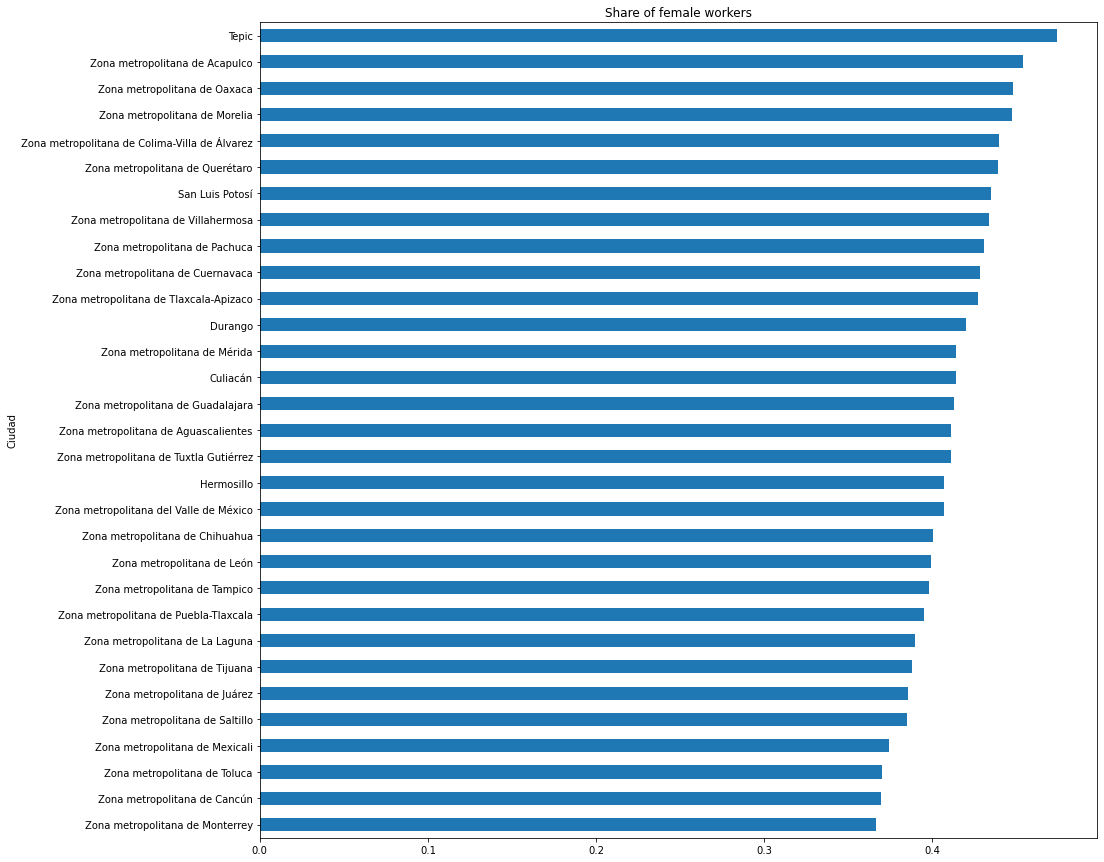

In [138]:
ejd_HH.loc['MEX']['mujer'].sort_values().plot(kind = 'barh', figsize = (15,15), title = 'Share of female workers')

### Indice HH Este ya lo tenés
### Principal sector: ya lo tenés
### Especialización relativa al país HH, ya lo tenés. Es HH calculado en la ciudad/ HH calculado en el país
### Principal sector en relación a la media nacional: Ya lo tenés, lo hicimos la otra vuelta
### N de clusters identificados en documentos de autoridad de gobierno local y que cuentan con plan estratégico.. Por ahora dejar anotado que no está hecho


### Facilitación de negocios

In [78]:
obstacles = [x for x in es_latest.columns if 'Biggest Obstacle' in x]

whole = []
for country in es_latest['Country'].unique():
    df1 = es_latest[es_latest['Country'] == country]
    for city in df1['City'].unique():
        df2 = df1[df1['City'] == city].set_index(['Country','City'])[obstacles]
        if df2.dropna().shape[0] != 0:
            stacked = df2.stack().sort_values(ascending = False).index.tolist()
            first = stacked[0][2]
            second = stacked[1][2]
            third = stacked[2][2]
            df2['first'] = first
            df2['second'] = second
            df2['third'] = third
            whole.append(df2)

all_ = obstacles + ['first', 'second', 'third']

es_obstacles = pd.concat(whole)[all_].reset_index()

es_obstacles['City'] = es_obstacles['City'].replace(fix)
es_obstacles = es_obstacles.set_index(['Country','City'])

In [79]:
top = ['first','second','third']

In [82]:
es_obstacles.loc['Mexico'][top]

,first,second,third
City,,,
Coahuila,Biggest Obstacle: Percent of firms choosing ac...,Biggest Obstacle: Percent of firms choosing in...,Biggest Obstacle: Percent of firms choosing el...
Estado de Mexico,Biggest Obstacle: Percent of firms choosing co...,Biggest Obstacle: Percent of firms choosing ac...,Biggest Obstacle: Percent of firms choosing cr...
Guanajuato,Biggest Obstacle: Percent of firms choosing ac...,Biggest Obstacle: Percent of firms choosing co...,Biggest Obstacle: Percent of firms choosing pr...
Jalisco,Biggest Obstacle: Percent of firms choosing cr...,Biggest Obstacle: Percent of firms choosing co...,Biggest Obstacle: Percent of firms choosing ta...
Ciudad de Mexico,Biggest Obstacle: Percent of firms choosing ta...,Biggest Obstacle: Percent of firms choosing bu...,Biggest Obstacle: Percent of firms choosing pr...
Nuevo Leon,Biggest Obstacle: Percent of firms choosing pr...,Biggest Obstacle: Percent of firms choosing la...,Biggest Obstacle: Percent of firms choosing co...
Puebla,Biggest Obstacle: Percent of firms choosing el...,Biggest Obstacle: Percent of firms choosing in...,Biggest Obstacle: Percent of firms choosing ac...
Veracruz,Biggest Obstacle: Percent of firms choosing ac...,Biggest Obstacle: Percent of firms choosing la...,Biggest Obstacle: Percent of firms choosing cr...


#### Doing Business

La información esta en varias tablas que separan por región/país. Los nombres de las columnas y variables no suelen ser los mismos entre tablas.
A continuación, concatenamos todas las tablas en una única tabla con la información desordenada, previo a una limpieza.

In [107]:
mex = pd.read_excel('worldbankdatabases/DB/processed/mex.xlsx', header = [0,1])
mex.columns = [x[0]+': '+ x[1] if 'Unnamed' not in x[0] else x[1] for x in mex.columns.tolist()]
mex = mex.drop('State', axis = 1).set_index('City')

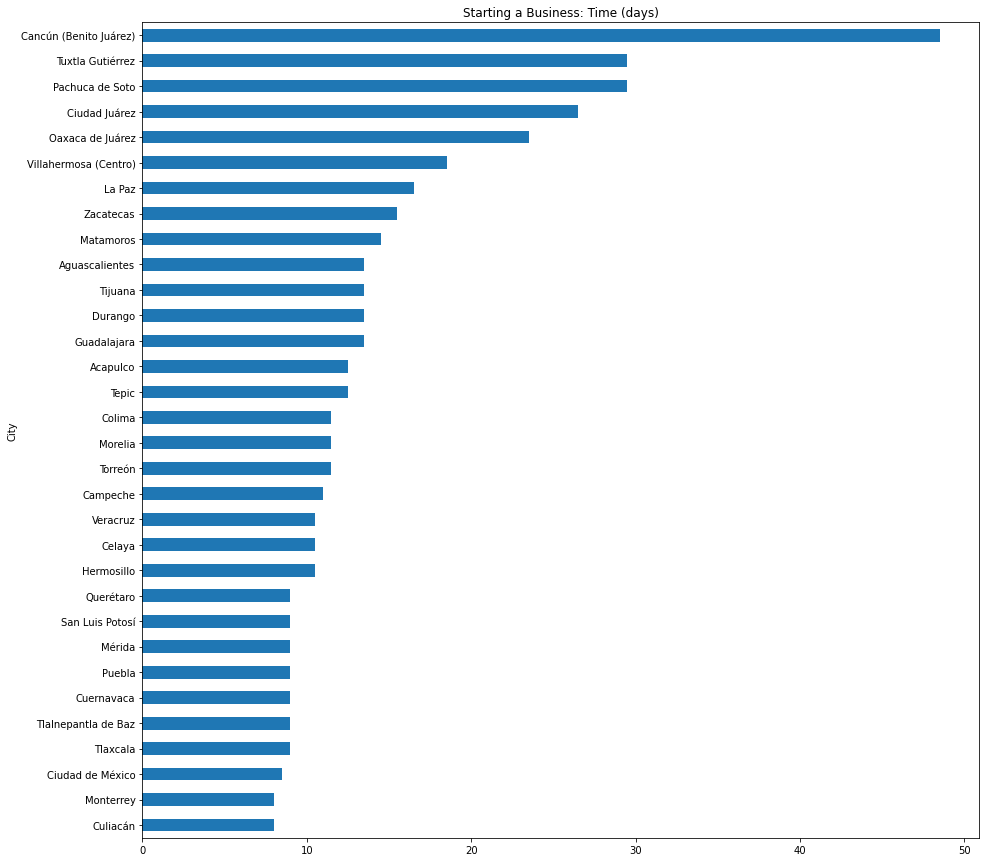

In [112]:
mex['Starting a Business: Time (days)'].sort_values().plot(
    kind = 'barh', figsize = (15,15), title = 'Starting a Business: Time (days)')

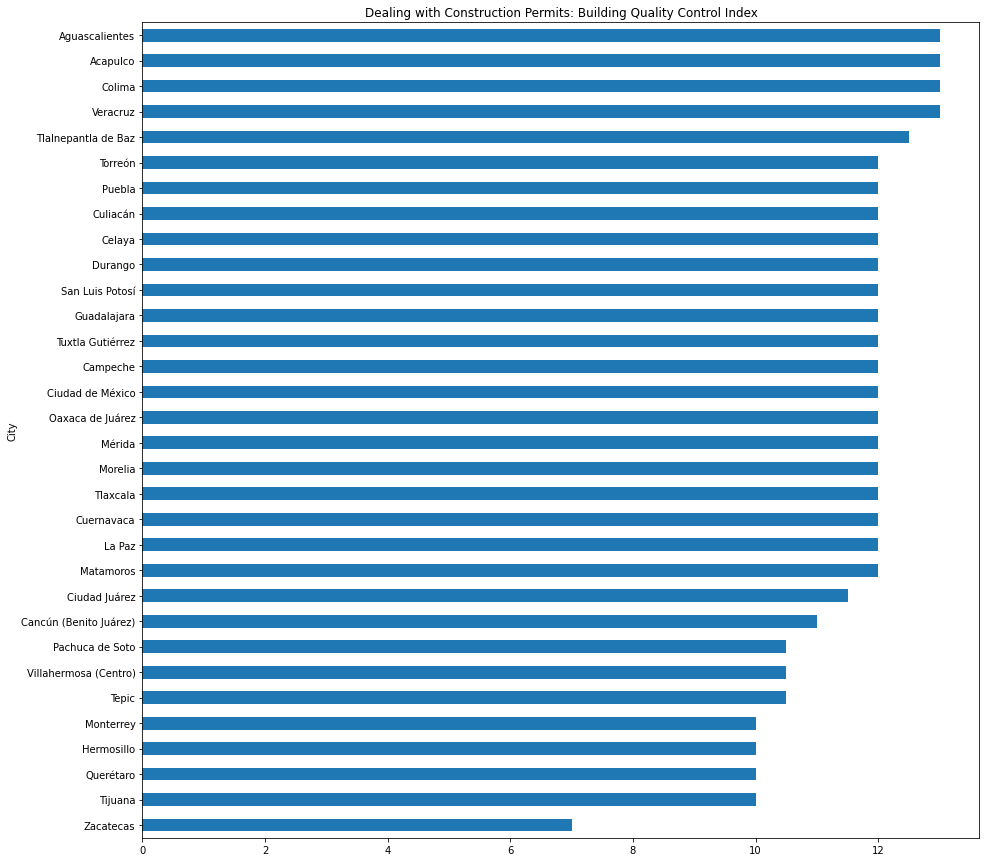

In [113]:
mex['Dealing with Construction Permits: Building Quality Control Index'].sort_values().plot(
    kind = 'barh', figsize = (15,15), title = 'Dealing with Construction Permits: Building Quality Control Index')

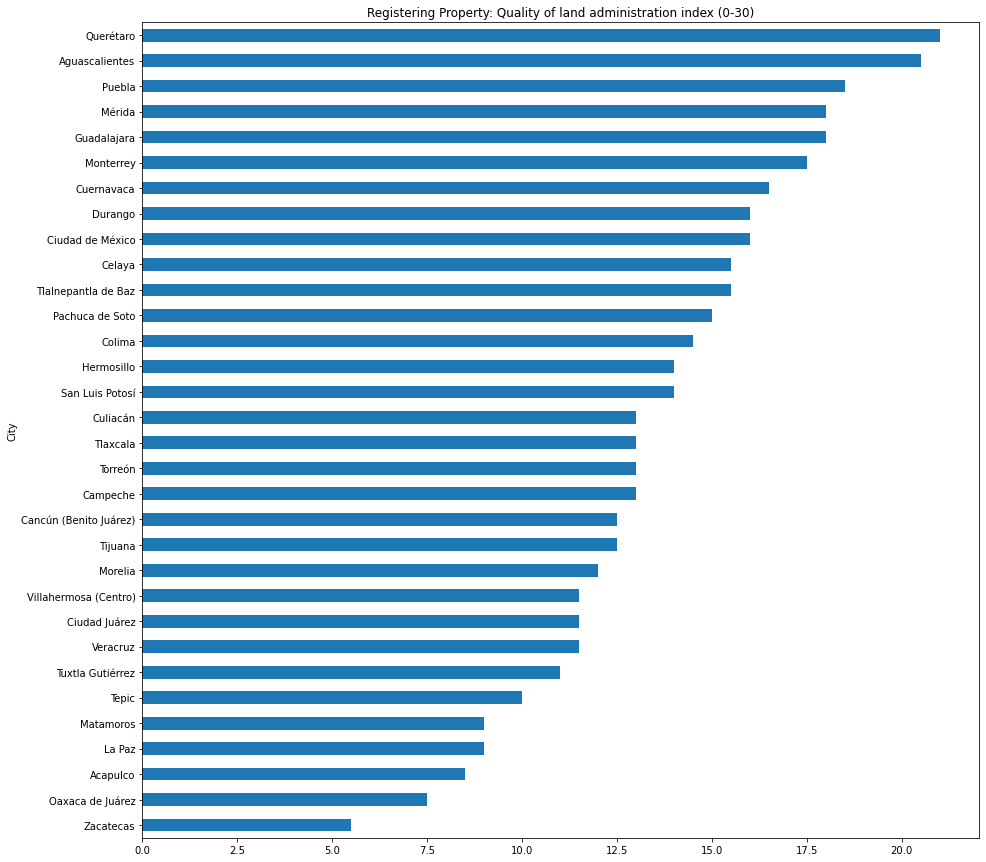

In [114]:
mex['Registering Property: Quality of land administration index (0-30)'].sort_values().plot(
    kind = 'barh', figsize = (15,15), title = 'Registering Property: Quality of land administration index (0-30)')

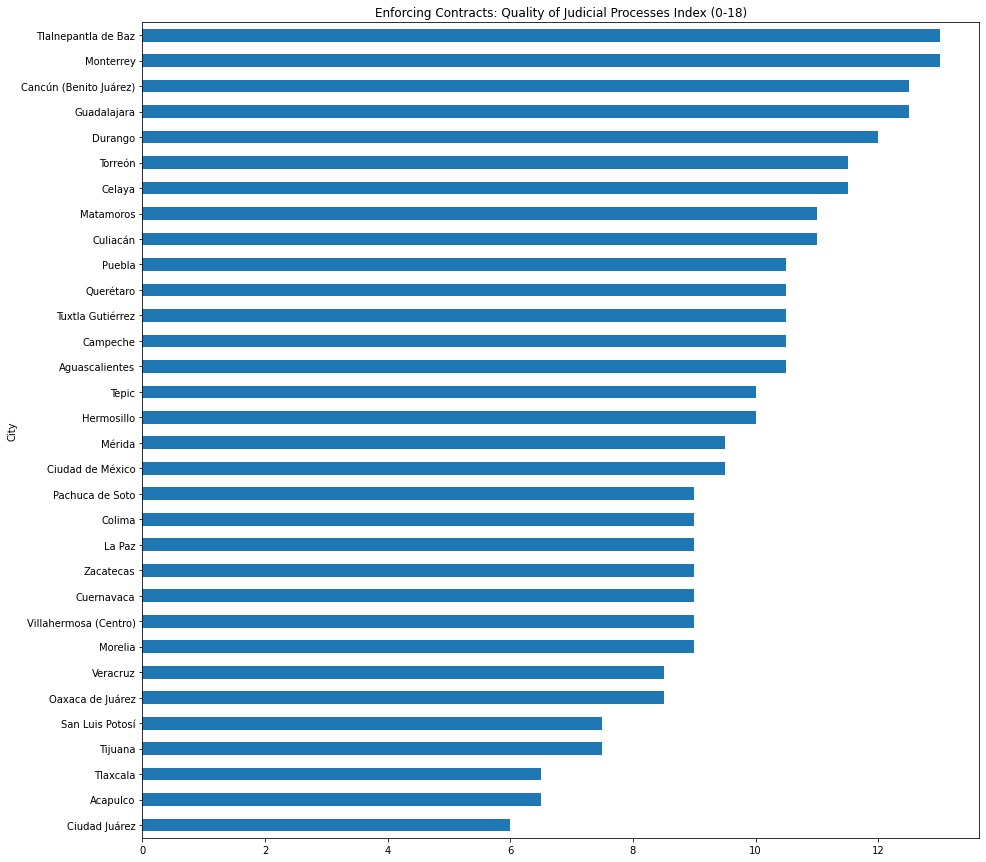

In [115]:
mex['Enforcing Contracts: Quality of Judicial Processes Index (0-18)'].sort_values().plot(
    kind = 'barh', figsize = (15,15), title = 'Enforcing Contracts: Quality of Judicial Processes Index (0-18)')

In [106]:
mex.columns

Index(['State', 'City',
       'Ease of Doing Business: Rank as published in Doing Business in Mexico 2016 Report',
       'Ease of Doing Business: Rank as of Current Data and Simulation ',
       'Ease of Doing Business: Aggegate Distance to the frontier* (4 indicators)',
       'Starting a Business: Procedures (number)',
       'Starting a Business: DTF Procedures',
       'Starting a Business: Time (days)', 'Starting a Business: DTF Time',
       'Starting a Business: Cost (% of income per capita)',
       'Starting a Business: DTF Cost',
       'Starting a Business: Paid-in Min. Capital (% of income per capita)',
       'Starting a Business: DTF PMC',
       'Starting a Business: Distance to the frontier Starting a Business (for agg rank)',
       'Starting a Business: Distance to the frontier Starting a Business',
       'Starting a Business: Ease of Starting a Business (RANK)',
       'Dealing with Construction Permits: Procedures (number)',
       'Dealing with Construction Perm

In [105]:
mex.head()

,State,City,Ease of Doing Business: Rank as published in Doing Business in Mexico 2016 Report,Ease of Doing Business: Rank as of Current Data and Simulation,Ease of Doing Business: Aggegate Distance to the frontier* (4 indicators),Starting a Business: Procedures (number),Starting a Business: DTF Procedures,Starting a Business: Time (days),Starting a Business: DTF Time,Starting a Business: Cost (% of income per capita),...,Registering Property: Ease of Property RANK,Enforcing Contracts: Time (days),Enforcing Contracts: DTF Time,Enforcing Contracts: Cost (% of claim),Enforcing Contracts: DTF Cost,Enforcing Contracts: Quality of Judicial Processes Index (0-18),Enforcing Contracts: DTF QJPI,Enforcing Contracts: Distance to the frontier Contracts (for agg rank),Enforcing Contracts: Distance to the frontier Contracts,Enforcing Contracts: Ease of Contracts RANK
0,Aguascalientes,Aguascalientes,1,1,81.90,8,58.823529,13.5,86.934673,6.223245,...,1,220,91.803279,19.677598,77.977955,10.5,58.333333,76.03819,76.04,6
1,Estado de México,Tlalnepantla de Baz,2,2,80.99,8,58.823529,9.0,91.457286,10.442814,...,7,191,94.180328,24.010980,73.103510,13.0,72.222222,79.83535,79.84,1
2,Colima,Colima,3,3,80.83,8,58.823529,11.5,88.944724,4.618745,...,4,210,92.622951,20.704974,76.822301,9.0,50.000000,73.14842,73.15,12
3,Puebla,Puebla,4,4,80.69,8,58.823529,9.0,91.457286,5.840448,...,3,207,92.868852,28.802281,67.713969,10.5,58.333333,72.97205,72.97,14
4,Sinaloa,Culiacán,5,5,79.80,7,64.705882,8.0,92.462312,20.020635,...,17,225,91.393443,20.738926,76.784110,11.0,61.111111,76.42955,76.43,5


In [ ]:
path = 'worldbankdatabases/DB/processed'

files = [x for x in os.listdir(path) if (x.endswith('xls'))|(x.endswith('xlsx'))]

big = []
for file in files:
    path_to_file = os.path.join(path, file)
    data = pd.read_excel(path_to_file, header = [0,1])
    big.append(data)

doing_business = pd.concat(big)

In [ ]:
properati_arg = pd.read_csv('properati/properati_arg')

In [ ]:
properati_arg.head()

### Para seguir aquí:
### Buscar dato para las ciudades de Mex nomás de la incidencia del crimen. El que encuentres más a mano. Hurto, homicidios, algun indice de seguridad algo
### Composición del crédito de empresas y Regulación del uso del suelo *a terminar